## __0. Download dataset__
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=f718040a-a421-4eb5-a24e-42b4007cc01d
To: /kaggle/working/vqa_coco_dataset.zip
100%|█████████████████████████████████████████| 196M/196M [00:01<00:00, 105MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

## __1. Import libraries and set random seed__

In [3]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 79.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 98.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 82.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 

In [4]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## __2. Read dataset__

In [6]:
train_data = []
train_set_path = 'vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

val_data = []
val_set_path = "/content/vaq2.0.DevImages.txt"

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

test_data = []
test_set_path = "/content/vaq2.0.TestImages.txt"

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [7]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx2label)

{0: 'no', 1: 'yes'}


## __3. Create Pytorch dataset__

In [8]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        transforms=None,
        img_dir='val2014-resised'
    ):
        self.data = data
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transforms:
            img = self.transforms(img)

        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k,v in img.items()}

            question = self.data[index]['question']
            if self.text_tokenizer:
                question = self.text_tokenizer(
                    question,
                    padding='max_length',
                    max_length=20,
                    truncation=True,
                    return_tensors='pt'
                )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}

            label = self.data[index]['answer']
            label = torch.tensor(
                self.label2idx[label],
                dtype=torch.long
            ).to(self.device)

            sample = {
                'image': img,
                'question': question,
                'label': label
            }

            return sample

In [9]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.CenterCrop(size=180),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(3),
])

In [10]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transform
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
train_batch_size = 768
test_batch_size = 256

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

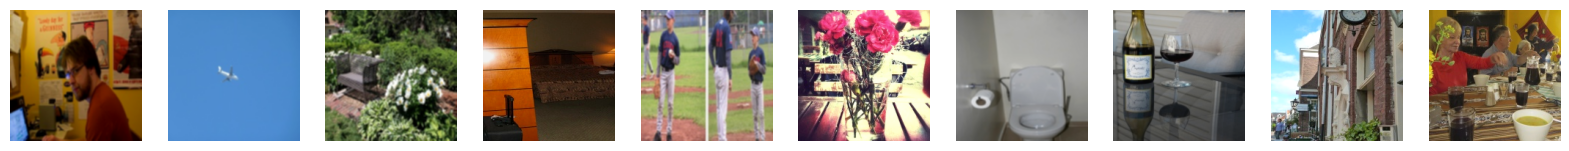

In [12]:
img_dir='val2014-resised/'
img_to_show = 10
shift = 10
test_imgs = [
    os.path.join(img_dir, sample['image_path']) for sample in train_data[shift:shift+img_to_show]
]
fig, axes = plt.subplots(nrows=1, ncols=img_to_show, figsize=(20, 4))
for ax, img_path in zip(axes, test_imgs):
    img_pil = Image.open(img_path).convert('RGB')
    preprocessed_img = data_transform(img_pil)
    ax.imshow(preprocessed_img)
    ax.axis('off')
plt.show()

## __4. Create VQA model__

In [13]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output

In [14]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output

In [15]:
class Classifier(nn.Module):
    def __init__(
        self,
        hidden_size=512,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier,self).__init__()
        self.fc1 = nn.Linear(768 * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self,x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x

In [16]:
import torch
import torch.nn as nn

class VQAModel(nn.Module):
    def __init__(self, visual_encoder, text_encoder, classifier):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier

    def forward(self, image, text):
        # Process image with visual encoder
        img_out = self.visual_encoder(image)  # Shape: (batch_size, visual_hidden_size)
        
        # Process text with text encoder
        text_out = self.text_encoder(text)  # Shape: (batch_size, text_hidden_size)
        
        # Concatenate outputs
        combined_out = torch.cat((img_out, text_out), dim=1)  # Shape: (batch_size, combined_hidden_size)
        
        # Classification
        output = self.classifier(combined_out)  # Shape: (batch_size, num_classes)
        return output

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n, p in self.visual_encoder.named_parameters():
                p.requires_grad = False
            print("Visual encoder frozen.")
        if textual:
            for n, p in self.text_encoder.named_parameters():
                p.requires_grad = False
            print("Text encoder frozen.")
        if clas:
            for n, p in self.classifier.named_parameters():
                p.requires_grad = False
            print("Classifier frozen.")


In [17]:
n_classes = len(classes)
hidden_size = 256
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual encoder frozen.
Text encoder frozen.


In [18]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(question, image)
    print(output.shape)

torch.Size([768, 2])


## __5. Training__

In [19]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(questions, images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [20]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(questions, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [21]:
lr = 1e-3
epochs = 50
scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## __6. Evaluation__

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

## __7. Inference__

In [ ]:
idx = 10
img_name = test_data[idx]['image_path']
img_path = os.path.join(img_dir, img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

question_processed = text_tokenizer(
    question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_tensors="pt"
).to(device)


img = Image.open(img_path).convert("RGB")
img_processed = img_feature_extractor(images=img, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.show()

print(f'Question: {question}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')